# Market Making Strategy
_Version 0.1_

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# load our helper functios
import simtools as st
import marketmaker as mm

matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )

### Load TAQ Data

We'll assume we have already done some cleaning by using our Tick Data Setup or similar code

In [2]:
# set up some variables
# NOTE: tickfile is a merged TAQ file!!!
tickfile = '../Data/TSLA-TAQ-aug19v2.zip'
taq = pd.read_pickle( tickfile )

In [3]:
# filter on date
test_day1 = '08/07/19'
test_day2 = '08/12/19'
day1 = taq[ test_day1 ]
day2 = taq[ test_day2 ]

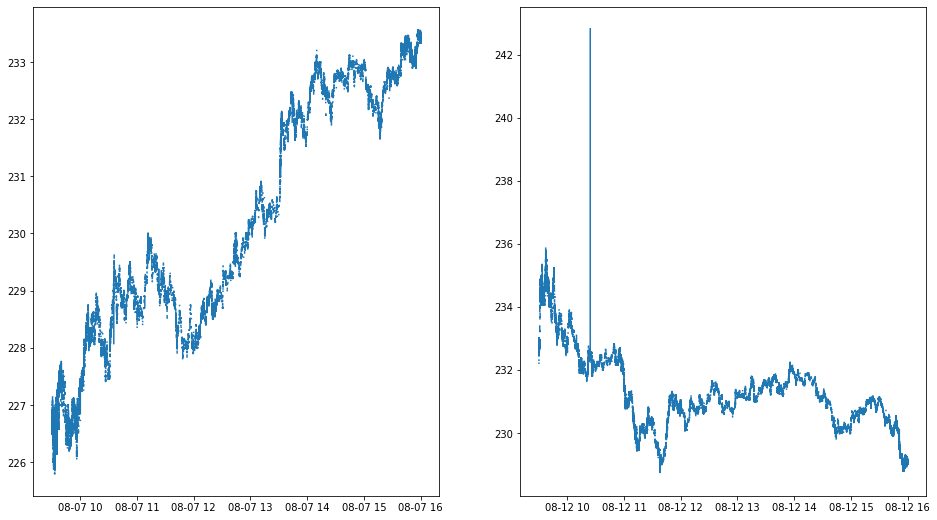

In [4]:
fig, ( plt1, plt2 ) = plt.subplots( 1, 2 )
plt1.plot( day1.trade_px )
plt2.plot( day2.trade_px )

## V1 - simple peg to BBO

In [5]:
# without the tick signal...
results = mm.algo_loop( day1, tick_coef=0, peg_to_bbo=True )

2020-03-04 00:07:32:276536: Beginning Market-Making Strategy run
Average stock spread for sample: 4.5576
2020-03-04 00:07:32:501933: starting main loop
2020-03-04 00:09:10:580807: end simulation loop
2020-03-04 00:09:10:580807: order analytics
buying to close residual of -29748.0 shares
2020-03-04 00:09:10:708971: Algo run complete.


In [6]:
print("buy count: {} sell count: {}".format(len(results['buys']), len(results['sells'])))

buy count: 14306 sell count: 16326


In [7]:
results.keys()

dict_keys(['midpoints', 'fair_values', 'tick_factors', 'buys', 'sells', 'quote_count', 'net_positions', 'residual_position'])

In [8]:
# TODO calc P&L
# price * shares / shares
buys = results['buys']
sells = results['sells']
avg_sell = ( sells.price * sells.shares ).sum() / sells.shares.sum()
avg_buy = ( buys.price * buys.shares ).sum() / buys.shares.sum()
PNL = avg_sell - avg_buy
print( "avg P&L per share: {}".format( PNL ) )

avg P&L per share: 0.08453615209089094


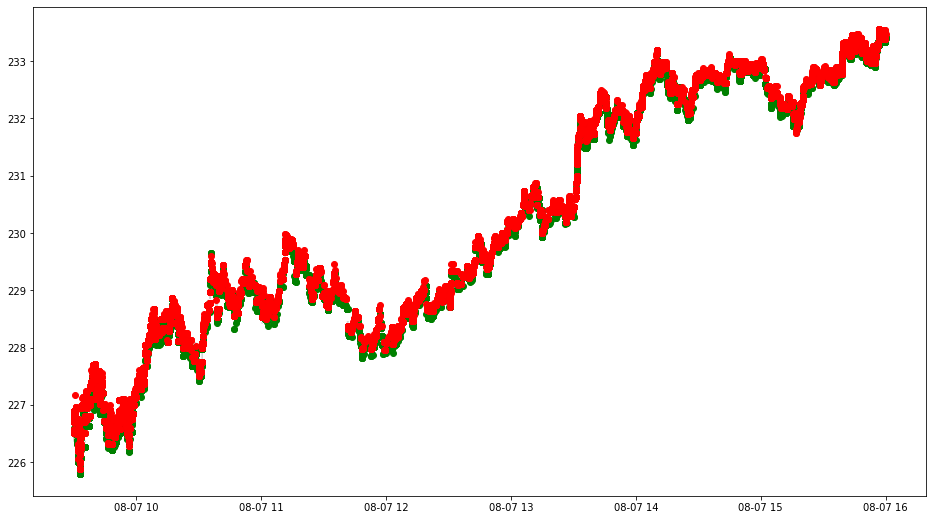

In [9]:
plt.plot(results['midpoints'], color="lightgray")
plt.plot(buys.price, "go")
plt.plot(sells.price, "ro")
plt.show()

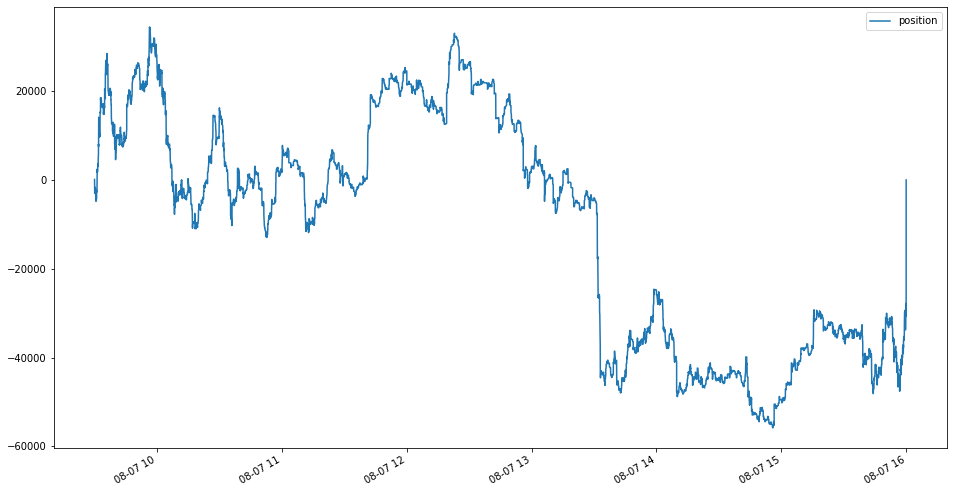

In [10]:
net_pos = results['net_positions'].dropna()
net_pos.plot()

In [11]:
results['residual_position']

0

That's a lot of trades!  It's also unrealistic in that we are being very over optimistic about the fill rate. 

I'll leave it as an exercise for the reader to explore that further and analyze the P&L as below.

## V2 - use tick signal to adjust

In [12]:
# without the tick signal...
results = mm.algo_loop( day1, tick_coef=1, peg_to_bbo=False )

2020-03-04 00:19:52:921705: Beginning Market-Making Strategy run
Average stock spread for sample: 4.5576
2020-03-04 00:19:53:139135: starting main loop
2020-03-04 00:21:22:636918: end simulation loop
2020-03-04 00:21:22:637432: order analytics
selling to close residual of 15165.0 shares
2020-03-04 00:21:22:764590: Algo run complete.


In [13]:
print("buy count: {} sell count: {}".format(len(results['buys']), len(results['sells'])))

buy count: 521 sell count: 325


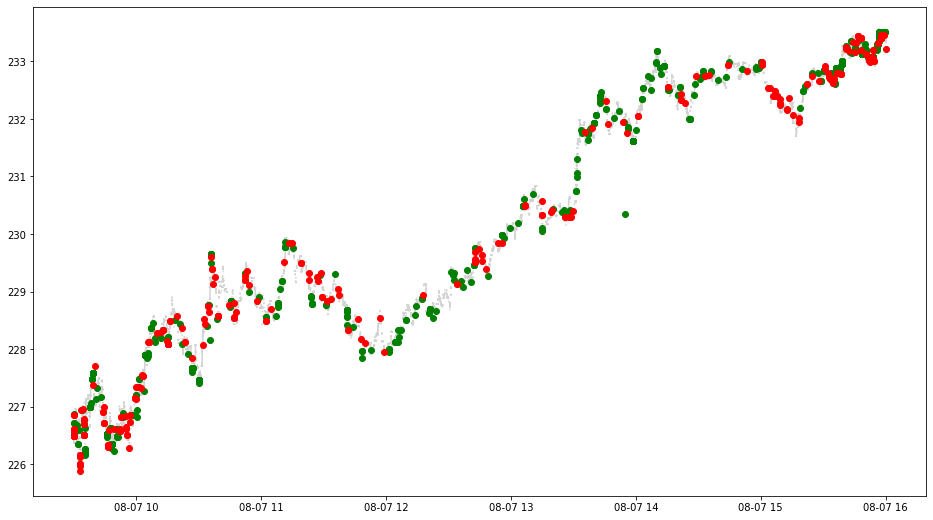

In [14]:
buys = results['buys']
sells = results['sells']
plt.plot(results['midpoints'], color="lightgray")
plt.plot(buys.price, "go")
plt.plot(sells.price, "ro")

### Performance

Since we are forcing net position to 0, for now we can just calculate a simple difference between avg buy and sell price.  Ideally we need to also calculate intraday P&L, etc. 

In [20]:
# TODO calc P&L
# price * shares / shares

avg_sell = ( sells.price * sells.shares ).sum() / sells.shares.sum()
avg_buy = ( buys.price * buys.shares ).sum() / buys.shares.sum()
PNL = avg_sell - avg_buy
print( "avg P&L per share: {}".format( PNL ) )

avg P&L per share: 0.8975618093415676


What about exposure? how much did we end up with on one side or the other?

In [21]:
# TODO: sum of buys and sells
net_residual = buys.shares.sum() - sells.shares.sum()
print(net_residual)

0.0


In [22]:
# lot net_positions

In [23]:
net_pos = results['net_positions'].dropna()

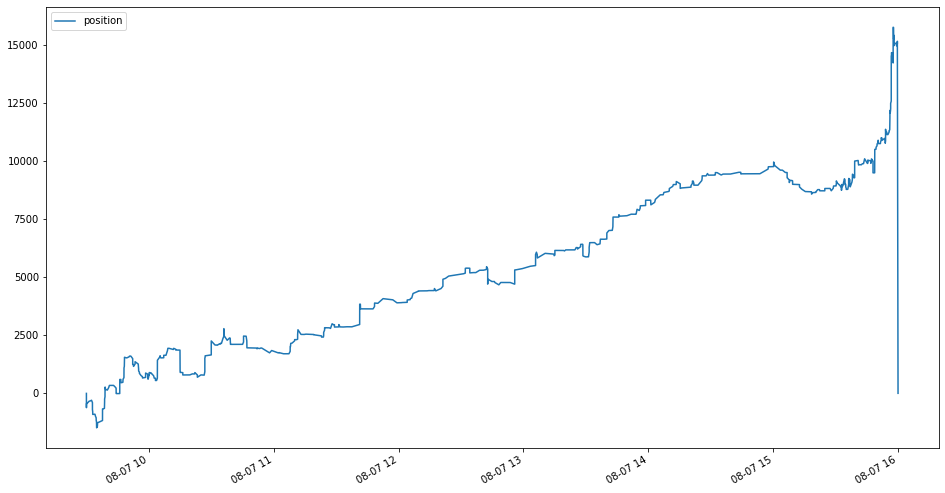

In [24]:
net_pos.plot()

### How about Day 2?

In [25]:
# without the tick signal...
results = mm.algo_loop( day2, tick_coef=1, peg_to_bbo=False )

2020-03-04 00:28:43:013818: Beginning Market-Making Strategy run
Average stock spread for sample: 12.1719
2020-03-04 00:28:43:233644: starting main loop
2020-03-04 00:30:39:750329: end simulation loop
2020-03-04 00:30:39:751326: order analytics
buying to close residual of -11026.0 shares
2020-03-04 00:30:39:919398: Algo run complete.


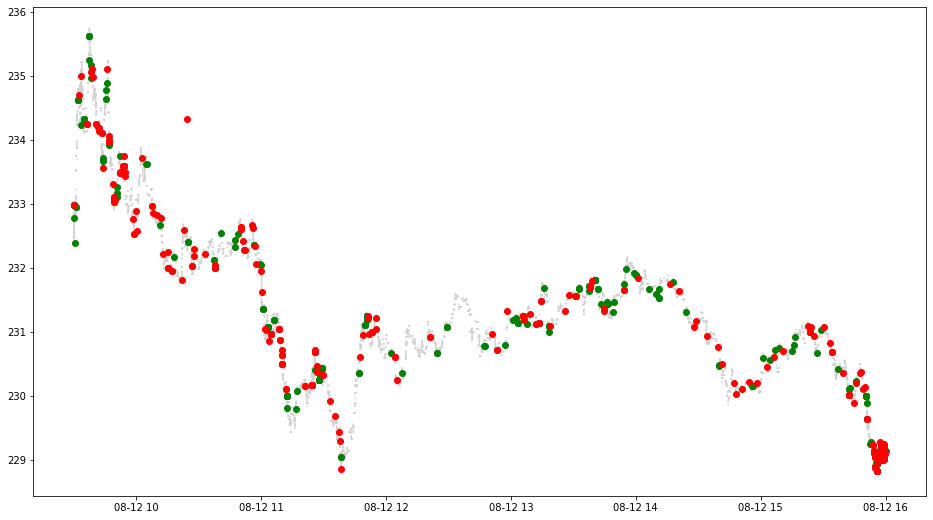

In [26]:
buys = results['buys']
sells = results['sells']
plt.plot(results['midpoints'], color="lightgray")
plt.plot(buys.price, "go")
plt.plot(sells.price, "ro")

In [27]:
print("buy count: {} sell count: {}".format(len(results['buys']), len(results['sells'])))

buy count: 262 sell count: 386


In [28]:
# calc P&L
# price * shares / shares

avg_sell = ( sells.price * sells.shares ).sum() / sells.shares.sum()
avg_buy = ( buys.price * buys.shares ).sum() / buys.shares.sum()
PNL = avg_sell - avg_buy
print( "avg P&L per share: {}".format( PNL ) )

avg P&L per share: 0.4498267750213927


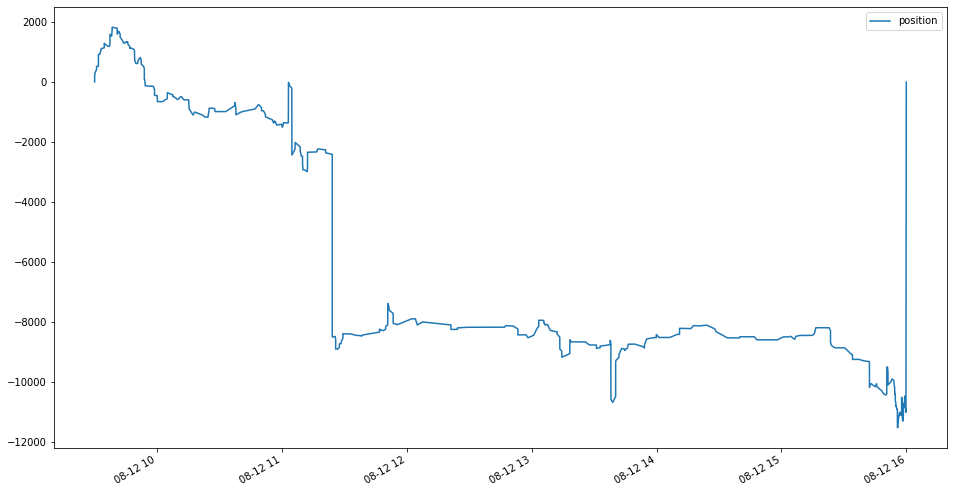

In [29]:
net_pos = results['net_positions'].dropna()
net_pos.plot()

### What Next?

Clearly this is not optimal behavior- our trading is unbounded and we're not doing anything to manage our risk

Future potential TODOs (aka "future homework")
1. Monitor P&L during simulation and consider a "stop loss" 
1. Add a "Position Risk" factor to modulate pricing to make position accumulation incrementally more difficult
1. Use a Position Risk factor to modulate order size
1. Add a hedging triggerd by exceeding some risk threshold